In [ ]:
%%bash
DATASETS_DIR="utils/datasets"
mkdir -p $DATASETS_DIR
cd $DATASETS_DIR

# Get Stanford Sentiment Treebank
if hash wget 2>/dev/null; then
  wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
else
  curl -L http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip -o stanfordSentimentTreebank.zip
fi
unzip stanfordSentimentTreebank.zip
rm stanfordSentimentTreebank.zip

# word2vec using `numpy`

In this notebook, I'll walk you through how to implement the popular and flexible word2vec model using `numpy`.

As well as showing how word2vec works, I also want to present to you a workflow that facilitates experimentation and ease of use that we'll carry through into all of our lessons on neural nets and deep learning. There are off-the-shelf implementations of this algorithm, but writing our own will help us better understand it, `numpy` and Python programming more generally.

* First, we'll need to work with the unique challenges of text data. We will develop some Python helper objects that will help us to convert our textual sources into tensors which can be mathematically manipulated.
* Next, we'll examine the word2vec Continuous Bag of Words (CBoW) and Skipgram architectures and how they work. In doing, we'll build out the `numpy` modules needed to turn these architectures from theory to practice.
* Last, we'll create a standard training loop which we can alter and experiment with.

The learning objectives for this notebook are as follows:
* Understand the advantages and disadvantages to neural approaches in NLP, and how this relates to our previous use of word2vec.
* Train and interpret their own word2vec model using a non-English language.
* Study the basics of the mathematical underpinnings of deep learning including backpropagation.
* Learn the ways to efficiently run deep learning models.

## Motivation

Before we dive into how it works, let's first take a look at what the goal of word2vec is. As the name implies, this very simple neural net seeks to transform words into numbers. A **vector**, in this sense, refers to a list of numbers whose values represent the meaning of a given word.

This probably sounds a little funky... Why do we need to convert words we know the meaning of into list of numbers whose meaning is hard to grasp? Ultimately, we want to give our computer a way of understanding text it hasn't seen before and unlike us a computer can't use text to learn meaning. *It can only use numbers*. What we really want is a some black-box that we can give a word and it will spit out the meaning of that word to the computer, a list of numbers. In fact, we want to *model* word meaning. This is what word2vec does.

As we will see, each unique word in our text will have an associated vector attached to it. This vector can be manipulated like any other vector, allowing us to apply complex mathematical operations to word meaning and sense.

In deep learning, this is called *feature extraction* because we are teaching a model how to extract the linguistic features from a word (though it could be anything, including images or audio). Feature extraction is rarely the end point in analysis. Instead, we can use these extracted features as the inputs to another model which will do some analysis. Before we get there though, let's look at how we can harness the power of word2vec.


In [ ]:
import numpy as np
import random

## Dataset

For this example, we will be using the Stanford Sentiment Treebank. This dataset has a lot of excerpts from English newspapers. They have been marked for sentiment value by human annotators, but we won't be using that data for this lesson. Let's take a look at what some of the data looks like.  

In [ ]:
path = "utils/datasets/stanfordSentimentTreebank"
with open(f"{path}/datasetSentences.txt", "r") as f:
    sentences = f.readlines()

for sentence in sentences[:6]:
    print(sentence)

These sources are in English (obviously), but the word2vec method is not tied to a particular language or dialect. What makes this framework so successful is that it is flexible and not language dependent. To that end, you will be apply this framework to a non-English language of your choice for your assignment.

### Tokenization

We need to do some processing to make this sentences usable and then we need to do some tokenization. We've talked a bit about tokenization before, but in this case we need to do it ourselves. We'll also need to skip the first line because it is just the column headings.

In the data below, we used "whitespace tokenization", that is, we split the sentence up on the space character (the default value for `.split` is `" "`). This strategy is very easy and works well for English, but may not work as well for other languages. We'll revisit multi-lingual tokenization later.

In [ ]:
print("Before Tokenization: ", sentences[6])
print(
    "After Tokenization: ", sentences[6].strip().split()[1:]
)  # "whitespace tokenization"

In [ ]:
path = "utils/datasets/stanfordSentimentTreebank"


def get_sentences():
    sentences = []
    with open(f"{path}/datasetSentences.txt", "r") as f:
        first = True
        for line in f:
            if first:
                first = False
                continue
            split = line.strip().split()[1:]
            sentences += [[w.lower() for w in split]]
    sent_lens = np.array([len(s) for s in sentences])
    cum_sent_lens = np.cumsum(sent_lens)
    return sentences, sent_lens, cum_sent_lens


sentences, sent_lens, cum_sent_lens = get_sentences()

for sent in sentences[:3]:
    print(sent)

In [ ]:
len(sentences), len(sentences[0])  # a list of list of strings (word/tokens)

### Creating our training dataset: Collation

We have done a good job in getting our data from the downloaded files and then tokenizing them, but unfortunately our dataset is far from usable to train a model. As I mentioned above, computers can't work directly with string or text data. Instead we will somehow need to convert our text into numbers, and not just that, we'll also need to arrange these numbers so that all of the lists of words are the same length. This means that even though we have a bunch of different sentences with different sizes, we need to standardize them to a single size. This process is called **collation**.

This size experts call `block_size` or `context_size` or `context_window`. You can think about it as the memory of the model. When the model is making predictions about what word will come next, it will only be able to use this context. As a result, we want `block_size` to be as high as possible, but we are limited by computational resources.

We will choose an arbitrary word as a *center* word. Then get all `block_size` words before and after the center word. From the `block_size` context, we want our model to predict the center word. This is how the model will learn (more on this in a bit). We will end up comparing the correct center word and the predicted center word and adjusting our model according to how similar or dissimilar they are.


Below is a diagram of this process using a `block_size` size of 2 (taken from: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).

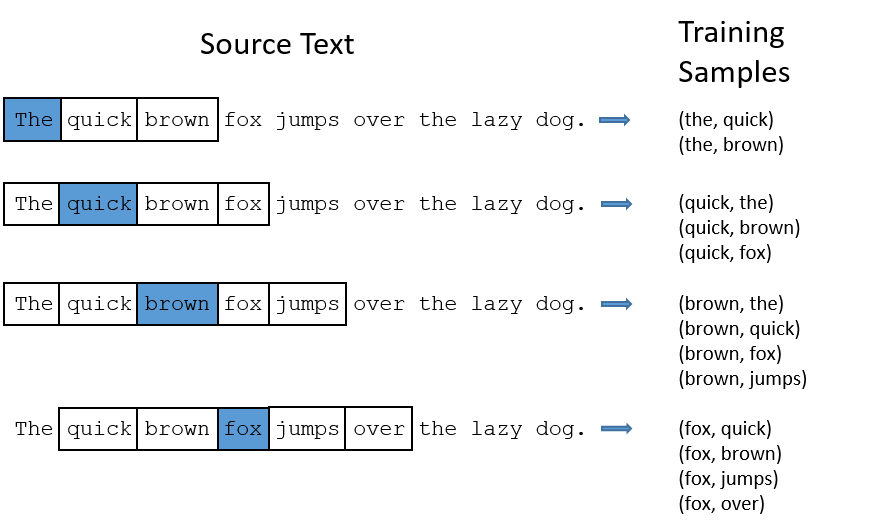



So first, we need to standardize our sentences so that they all have the same context size. We will set a center token and then retrieve C words before and after it.

In [ ]:
def get_random_context(C=5):
    sent_id = random.randint(0, len(sentences) - 1)
    sent = sentences[sent_id]
    word_id = random.randint(0, len(sent) - 1)

    context = sent[max(0, word_id - C) : word_id]
    if word_id + 1 < len(sent):
        context += sent[word_id + 1 : min(len(sent), word_id + C + 1)]

    center = sent[word_id]
    context = [w for w in context if w != center]

    if len(context) > 0:
        return center, context
    else:
        return get_random_context(C)

In [ ]:
center, context = get_random_context()
center, context  # we will use the context words to predict the center word

"But," you may be asking yourself, "this doesn't solve the problem about computers not being able to read text at all! We still have strings! What gives, Peter >:("

Good point! That part is a bit easier: Because our center word is picked randomly, we can assign each word in our text a number somewhat at random. In fact, we will go sequentially and assign a *token id* to each word that we haven't seen before. We will create two dictionaries: one with keys that are each word and values are their token id, and another with keys that are the token ids and the values are their words.   

In [ ]:
def get_tokens():
    tokens = {}
    tok_freq = {}
    word_count = 0
    rev_tokens = []
    idx = 0

    for sent in sentences:
        for w in sent:
            word_count += 1
            if w not in tokens:
                tokens[w] = idx
                rev_tokens += [w]
                idx += 1
                tok_freq[w] = 1
            else:
                tok_freq[w] += 1

    tokens["UNK"] = idx
    rev_tokens += ["UNK"]
    tok_freq["UNK"] = 1
    word_count += 1
    return tokens, tok_freq, rev_tokens, word_count


tokens, tok_freq, rev_tokens, word_count = get_tokens()
len(tokens), len(tok_freq), len(rev_tokens), word_count

In [ ]:
print("Center word: *", center, "* Center word token id: ", tokens[center])
for i in range(len(context)):
    print(
        "Context word: *", context[i], "* Context word token id: ", tokens[context[i]]
    )

### Negative Sampling

We'll come back to this if we have time

In [ ]:
# the data came with some splits in our data
# we can apply them with this function
def dataset_split():
    split = [[] for _ in range(3)]
    with open(f"{path}/datasetSplit.txt", "r") as f:
        first = True
        for line in f:
            if first:
                first = False
                continue
            split = line.strip().split(",")
            split[int(split[1]) - 1] += [int(split[0]) - 1]
    return split


split = dataset_split()
len(split), len(split[0]), len(split[1]), len(split[2])

In [ ]:
table_size = 1e8


def sampleTable():
    tokens_num = len(tokens)
    sampling_freq = np.zeros((tokens_num,))

    i = 0
    for w in range(tokens_num):
        w = rev_tokens[i]
        if w in tok_freq:
            freq = 1.0 * tok_freq[w]
            freq = freq**0.75
        else:
            freq = 0.0
        sampling_freq[i] = freq
        i += 1

    sampling_freq /= np.sum(sampling_freq)
    sampling_freq = np.cumsum(sampling_freq) * table_size

    sample_table = np.zeros((int(table_size),))

    j = 0
    for i in range(int(table_size)):
        while i > sampling_freq[j]:
            j += 1
        sample_table[i] = j

    return sample_table


sample_table = sampleTable()

In [ ]:
def reject_prob():
    threshold = 1e-5 * word_count
    reject_prob = np.zeros((len(tokens),))
    for i in range(len(tokens)):
        w = rev_tokens[i]
        freq = 1.0 * tok_freq[w]
        reject_prob[i] = max(0, 1 - np.sqrt(threshold / freq))
    return reject_prob


reject_prob = reject_prob()

### Our complete dataset object

Now that we have coded out the data specific functions, we can compile it all into a single class from which we can call these functions.

In [ ]:
class StanfordSentiment:
    """
    Class for reading and loading Stanford Sentiment Treebank. We ignore the sentiment component of the treebank and extract just the text.
    """

    def __init__(self, path=None, table_size=1000000):
        if not path:
            path = "utils/datasets/stanfordSentimentTreebank"

        self.path = path
        self.table_size = table_size

        self.get_sentences()
        self.get_tokens()
        self.get_all_sentences()
        self.dataset_split()
        self.sampleTable()

    def get_tokens(self):
        if hasattr(self, "tokens") and self.tokens:
            return self.tokens

        tokens = {}
        tok_freq = {}
        word_count = 0
        rev_tokens = []
        idx = 0

        for sent in self.sentences:
            for w in sent:
                word_count += 1
                if w not in tokens:
                    tokens[w] = idx
                    rev_tokens += [w]
                    idx += 1
                    tok_freq[w] = 1
                else:
                    tok_freq[w] += 1

        tokens["UNK"] = idx
        rev_tokens += ["UNK"]
        tok_freq["UNK"] = 1
        word_count += 1

        self.tokens = tokens
        self.tok_freq = tok_freq
        self.rev_tokens = rev_tokens
        self.word_count = word_count
        return self.tokens

    def get_sentences(self):
        if hasattr(self, "sentences") and self.sentences:
            return self.sentences

        sentences = []
        with open(f"{self.path}/datasetSentences.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue
                split = line.strip().split()[1:]
                sentences += [[w.lower() for w in split]]
        sent_lens = np.array([len(s) for s in sentences])
        cum_sent_lens = np.cumsum(sent_lens)

        self.sentences = sentences
        self.sent_lens = sent_lens
        self.cum_sent_lens = cum_sent_lens
        return sentences

    def get_reject_prob(self):
        if hasattr(self, "reject_prob") and self.reject_prob:
            return self.reject_prob

        threshold = 1e-5 * self.word_count
        reject_prob = np.zeros((len(self.tokens),))
        n_tokens = len(self.tokens)
        for i in range(n_tokens):
            w = self.rev_tokens[i]
            freq = 1.0 * self.tok_freq[w]
            reject_prob[i] = max(0, 1 - np.sqrt(threshold / freq))
        self.reject_prob = reject_prob
        return reject_prob

    def get_all_sentences(self):
        if hasattr(self, "all_sentences") and self.all_sentences:
            return self.all_sentences

        sentences = self.get_sentences()
        reject_prob = self.get_reject_prob()
        tokens = self.get_tokens()
        all_sentences = [
            [
                w
                for w in s
                if 0 >= reject_prob[tokens[w]]
                or random.random() >= reject_prob[tokens[w]]
            ]
            for s in sentences * 30
        ]
        all_sentences = [s for s in all_sentences if len(s) > 1]
        self.all_sentences = all_sentences
        return all_sentences

    def get_random_context(self, C=5):
        sentences = self.get_all_sentences()
        sent_id = random.randint(0, len(sentences) - 1)
        sent = sentences[sent_id]
        word_id = random.randint(0, len(sent) - 1)

        context = sent[max(0, word_id - C) : word_id]
        if word_id + 1 < len(sent):
            context += sent[word_id + 1 : min(len(sent), word_id + C + 1)]

        center = sent[word_id]
        context = [w for w in context if w != center]

        if len(context) > 0:
            return center, context
        else:
            return self.get_random_context(C)

    def dataset_split(self):
        if hasattr(self, "split") and self.split:
            return self.split

        split = [[] for _ in range(3)]
        with open(f"{self.path}/datasetSplit.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue
                split = line.strip().split(",")
                split[int(split[1]) - 1] += [int(split[0]) - 1]
        self.split = split
        return split

    def sampleTable(self):
        if hasattr(self, "sample_table") and self.sample_table:
            return self.sample_table

        tokens_num = len(self.tokens)
        sampling_freq = np.zeros((tokens_num,))

        i = 0
        for w in range(tokens_num):
            w = self.rev_tokens[i]
            if w in self.tok_freq:
                freq = 1.0 * self.tok_freq[w]
                freq = freq**0.75
            else:
                freq = 0.0
            sampling_freq[i] = freq
            i += 1

        sampling_freq /= np.sum(sampling_freq)
        sampling_freq = np.cumsum(sampling_freq) * self.table_size

        self.sample_table = np.zeros((int(self.table_size),))

        j = 0
        for i in range(int(self.table_size)):
            while i > sampling_freq[j]:
                j += 1
            self.sample_table[i] = j

        return self.sample_table

    def get_random_train_sentence(self):
        split = self.dataset_split()
        sent_id = random.choice(split[0])
        return self.all_sentences[sent_id]

    def get_split_sentences(self, split=0):
        split = self.dataset_split()
        sentences = [self.all_sentences[i] for i in split[split]]
        return sentences

    def get_train_sentences(self):
        return self.get_split_sentences(0)

    def get_test_sentences(self):
        return self.get_split_sentences(1)

    def get_val_sentences(self):
        return self.get_split_sentences(2)

    def sampleTokenIdx(self):
        return self.sample_table[random.randint(0, self.table_size - 1)]

In [ ]:
dataset = StanfordSentiment()  # takes about 45sec

In [ ]:
tokens = dataset.tokens
num_words = len(tokens)
print(num_words)

## Model

As I mentioned in the motivation, we are trying to create a model that gives us a vector for each word that represents the meaning of that word. How could we do this?

It may not seem like it but the problem is of the shape: $y = Ax$, where $x$ is our inputs, in our case the context words, $y$ is our expected outputs, in our case the center word. Like I said, we are going to have our model predict a center word from the context words and then compare that prediction to the actual center word. Based on how close we were, we can then adjust the model so that it does a better job on another training example. This leaves two major questions:

1. How can we measure similarity between words mathematically?
2. How can we "adjust" our model? What does that even mean?

### Stochastic Gradient Descent
Luckily, there is a single process which will answer both of this questions.

> Before we discuss this topic, realize that no one just woke up one day and "discovered" this process. It took decades of mathematical and computational experimentation to develop. To that end, I do not expect you to *just* understand it, instead I want you to compile questions that you have. Pay close attention to what are you confused about and where you stop understanding.

It is called Stochastic Gradient Descent or SGD and it will allow us both to create a quantitative similarity metric and to "learn" from what it tells us. As I posited above, this problem can be simiplied to the following: $y = Ax$, where $x$ is our inputs, in our case the context words, $y$ is our expected outputs, in our case the center word. In that case, what is $A$? $A$ will be matrix of "weights" which when multiplied by our $x$s will product our $y$s.

We don't know need to figure out $A$. It will start out as completely random and then we will learn its value through training. Importantly, each row in the $A$ matrix is a single vector representing a word, so it will be as long as our entire vocabulary. So for each word in our text, we will have a initially random vector, whose size we will called `embedding_dim` or embedding dimension.

Now that each word has a (random) vector associated with it, we can directly compare them. Using the **the scaled dot product**, we can determine how similar two vectors are. The scaled dot product ($x \cdot y$) between two vectors will produce a number between -1 and 1, representing how similar or dissimilar a vector is from any other. This answers our first question above.

Before we attack the second question, let's first take a look at what we just described looks like in code.

In [ ]:
vector_dim = 10
word_vecs = np.concatenate(
    (
        (np.random.rand(num_words, vector_dim) - 0.5) / vector_dim,
        np.zeros(
            (num_words, vector_dim)
        ),  # for simplicity's sake, we will have a separate set of vectors for each context word as well as for each center word
    ),
    axis=0,
)

word_vecs.shape  # 2*num_words (one for the context vector and another for the center vector) x vector_dim
# initially random vectors

In [ ]:
# getting center word vecs and context word vecs
# each word will have two word vectors: center and context, we will only care about the center word vectors
center_word_vecs = word_vecs[:num_words, :]
outside_word_vecs = word_vecs[num_words:, :]

In [ ]:
block_size = 5
center_word, context = dataset.get_random_context(block_size)
center_word, context  # get a center word and context

In [ ]:
# find index of center word
center_word_idx = dataset.tokens[center_word]
center_word_idx

In [ ]:
# getting the random word vec for this index/word
center_word_vec = center_word_vecs[center_word_idx]
center_word_vec  # still random

Now that we are able to get the center word vector, we can get the vectors for the outside words in the same way. For each one, we are going to take the similarity (dot product) between it and and the center word vector.

In [ ]:
# example with just one outside word
outside_word_idx = dataset.tokens[context[1]]
outside_word_idx

In [ ]:
outside_word_vec = outside_word_vecs[outside_word_idx]
outside_word_vec  # start as zeros

In [ ]:
dot_products = np.dot(
    outside_word_vecs, center_word_vec
)  # take the dot product between all outside words and the center word
dot_products.shape

In [ ]:
# let's see what this dot product produces
import matplotlib.pyplot as plt

plt.plot(dot_products)
plt.show()  # it's all zeros because all of the outside word vectors are zero

How can we take these numbers and get a prediction for word? Remember what we want to do: compare a predicted word to the actually correct center word. But right now all we have an array of zeros. How can we turn this into a prediction?

We will be using something called the **softmax** function, which is defined as: $\sigma(x_i) = \dfrac{e^{x_i}}{\sum_{j=1}^{K}e^{x_j}}$. This might look really scary, but don't worry. All this function does is turn a set of numbers into a probability distribution. See below.

In [ ]:
def softmax(x):
    orig_shape = x.shape

    if len(x.shape) > 1:
        # Matrix
        tmp = np.max(x, axis=1)
        x -= tmp.reshape((x.shape[0], 1))
        x = np.exp(x)
        tmp = np.sum(x, axis=1)
        x /= tmp.reshape((x.shape[0], 1))
    else:
        # Vector
        tmp = np.max(x)
        x -= tmp
        x = np.exp(x)
        tmp = np.sum(x)
        x /= tmp

    assert x.shape == orig_shape
    return x

In [ ]:
softmax_probs = softmax(dot_products)
softmax_probs.shape

In [ ]:
softmax_probs[0]

In [ ]:
# let's see what this looks like
plt.hist(softmax_probs)
plt.show()  # probabilities are even, at zero, as you might expect

In this case, all of the words have the same probability: zero or almost zero (~5e-5), as softmax cannot output a value of zero. As a result, we can pick any word and compare it to our center word. To do so, we introduce a value called *loss* which represents how close we are to the true word for a given training example. There are many ways to calculate a loss, but because we are picking individual words, we are going to use **negative log likelihood**: $Loss = -y_{o,c}\ln(p_{o,c})$.

This also probably looks scary, but all it says is that we take the predicted word and the correct word and from their dot product can calculate a single number.

In [ ]:
loss = -np.log(softmax_probs[outside_word_idx])  # nll in code
loss
# this number represents how good our prediction is
# zero is the lowest number that we can predict

### Stochastic Gradient Descent continued

We have completed one half of our model! What we just did was called the **forward pass**. We are now going to investigate the **backwards pass**.

It is called a backward pass because we are going to go backwards through all of the steps in the forward pass to figure out what we need to do to make the prediction better. This process is also called *back propagation* or *backprop*.

So we need to figure out what elements of our $A$ matrix (our word vectors) we need to change, and how to change them, so that we **minimize our loss**. This is an *optimization* problem, meaning we need to determine the *most optimal* values for each cell of $A$ such that the loss between the predicted $y$s and the actual $y$s is the lowest we can make it. Thus, when our loss has reached the lowest it will go, we will have trained our word vectors so that they actually represent the meaning of their respective words. We will be able to show this by the end.

But how do we optimize? Well, it involves some calculus. We want to see how much we need to change each and every element of $A$, so we use a *derivative*, which will tell us how far away we are from reaching the lowest point in our loss function.

Thankfully, the derivatives we will need to calculate are fairly simple. All we have done is some multiplication and addition, which are very easy to take the derivative of. Don't worry about this though, the derivatives will be provided below.

Once we have the derivative, we can take a small step in that direction by multiplying it by a small number (called a step size or learning rate) and subtract it from our values of $A$.


In [ ]:
# let's see an example in code
loss  # need to differential with respect to all of the values of A

In [ ]:
current_grad_center_vec = -outside_word_vecs[outside_word_idx] + np.dot(
    softmax_probs, outside_word_vecs
)  # derivative of dot product for the center word vec
current_grad_center_vec

In [ ]:
current_grad_outside_vecs = np.outer(
    softmax_probs, center_word_vec
)  # derivative of dot product for the outer word vecs
current_grad_outside_vecs[outside_word_idx] -= center_word_vec
current_grad_outside_vecs

In [ ]:
grad_center_vecs = np.zeros(center_word_vecs.shape)  # holder for our derivative values
grad_outside_vecs = np.zeros(
    outside_word_vecs.shape
)  # holder for our derivative values

grad_center_vecs[center_word_idx] += current_grad_center_vec
grad_outside_vecs += current_grad_outside_vecs

In [ ]:
# now that we've calculated our derivatives we can take a step
step = 1
center_word_vecs -= step * grad_center_vecs
outside_word_vecs -= step * grad_outside_vecs

In [ ]:
# and then run another forward pass
dot_products = np.dot(outside_word_vecs, center_word_vec)
dot_products  # longer zero!

In [ ]:
softmax_probs = softmax(dot_products)
softmax_probs  # a bit more variation!

In [ ]:
loss = -np.log(softmax_probs[outside_word_idx])
loss  # slight lower!!

### Negative Sampling

We just saw how using softmax and ggradient descent can reduce our loss, meaning that we can learn word meaning and represent that meaning with vectors! That's great, but it takes too long. Softmax is a very expensive operation. We'll use it in later lessons, but here, we're going to use a similar technique, but a different activation function: **sigmoid**. Additionally, instead of applying softmax to every context word vector. We are only going to sample a small subset and estimate the loss based on that sample. This process is called *negative sampling*.

Sigmoid is defined as follows: $\frac{1}{1+e^{-x}}$

Like softmax, sigmoid, transforms a set of numbers into probability distribution by not allowing any numbers greater than 1 or less than 0.

Let's run through an example of negative sampling in code now.

In [ ]:
# new example copying from above
vector_dim = 10
word_vecs = np.concatenate(
    (
        (np.random.rand(num_words, vector_dim) - 0.5) / vector_dim,
        np.zeros(
            (num_words, vector_dim)
        ),  # for simplicity's sake, we will have a separate set of vectors for each context word as well as for each center word
    ),
    axis=0,
)

block_size = 5
center_word, context = dataset.get_random_context(block_size)

center_word_idx = dataset.tokens[center_word]
center_word_vec = word_vecs[center_word_idx]

outside_word_idxs = [dataset.tokens[w] for w in context]

center_word_vecs = word_vecs[:num_words, :]
outside_word_vecs = word_vecs[num_words:, :]

In [ ]:
# first we need a data structure from which we can easily sample from
# we can use a table of values
table_size = 1e8


def sampleTable():
    tokens_num = len(tokens)
    sampling_freq = np.zeros((tokens_num,))

    i = 0
    for w in range(tokens_num):
        w = rev_tokens[i]
        if w in tok_freq:
            freq = 1.0 * tok_freq[w]
            freq = freq**0.75
        else:
            freq = 0.0
        sampling_freq[i] = freq
        i += 1

    sampling_freq /= np.sum(sampling_freq)
    sampling_freq = np.cumsum(sampling_freq) * table_size

    sample_table = np.zeros((int(table_size),))

    j = 0
    for i in range(int(table_size)):
        while i > sampling_freq[j]:
            j += 1
        sample_table[i] = j

    return sample_table


sample_table = sampleTable()

In [ ]:
sample_table[random.randint(0, table_size - 1)]

In [ ]:
negSampleWordIndices = [None] * 5
for k in range(5):
    newidx = sample_table[random.randint(0, table_size - 1)]
    print(newidx)
    negSampleWordIndices[k] = newidx
[int(n) for n in negSampleWordIndices]

In [ ]:
# function version
def get_negative_samples(outsideWordIdx, dataset, K):
    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return [int(n) for n in negSampleWordIndices]

In [ ]:
outside_word_idx = outside_word_idxs[0]

neg_samples = get_negative_samples(outside_word_idx, dataset, 5)
neg_samples  # neg samples

In [ ]:
grad_center_vec = np.zeros(center_word_vec.shape)
grad_outside_vecs = np.zeros(outside_word_vecs.shape)

In [ ]:
u_0 = outside_word_vecs[outside_word_idx]
u_0  # vector for the true context word

In [ ]:
z_0 = np.dot(u_0, center_word_vec)
z_0  # dot product as before

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


p_0 = sigmoid(z_0)
p_0  # new sigmoid transformation

In [ ]:
loss = -np.log(p_0)  # loss for just this part
loss

In [ ]:
# derivatives for this part
grad_center_vec += (p_0 - 1) * u_0
grad_outside_vecs[outside_word_idx] += (p_0 - 1) * center_word_vec

In [ ]:
for k in neg_samples:  # loop through neg sample idxs
    u_k = outside_word_vecs[k]  # find the correct context vector for a sample idx
    z_k = np.dot(u_k, center_word_vec)  # take the dot product as above
    p_k = sigmoid(-z_k)  # activate using sigmoid
    loss -= np.log(p_k)  # calculate the loss

    # derivatives for this negative sample
    grad_center_vec -= (p_k - 1) * u_k
    grad_outside_vecs[k] -= (p_k - 1) * center_word_vec

In [ ]:
loss  # new loss about neg sampling

In [ ]:
# example backwards pass
step = 1
center_word_vecs -= step * grad_center_vecs
outside_word_vecs -= step * grad_outside_vecs

In [ ]:
# checking if our grad descent worked like last time
loss = 0.0
u_0 = outside_word_vecs[outside_word_idx]
z_0 = np.dot(u_0, center_word_vec)
p_0 = sigmoid(z_0)
loss = -np.log(p_0)

for k in neg_samples:
    u_k = outside_word_vecs[k]
    z_k = np.dot(u_k, center_word_vec)
    p_k = sigmoid(-z_k)
    loss -= np.log(p_k)

loss  # went down slightly!

## Running the model

We have covered *A LOT* this lesson, so I have assembled the functions that we will need to train the model below. You have seen all of the code in them, though the presentation/order might be a little weird.

In [ ]:
def w2v_wrapper(model, w2i, word_vecs, dataset, block_size, loss_and_grad):
    batch_size = 50
    loss = 0.0
    grad = np.zeros(word_vecs.shape)
    N = word_vecs.shape[0]
    center_word_vecs = word_vecs[: int(N / 2), :]
    outside_word_vecs = word_vecs[int(N / 2) :, :]
    for i in range(batch_size):
        block_size1 = random.randint(1, block_size)
        center_word, context = dataset.get_random_context(block_size1)

        c, grad_in, grad_out = model(
            center_word,
            block_size1,
            context,
            w2i,
            center_word_vecs,
            outside_word_vecs,
            dataset,
            loss_and_grad,
        )
        loss += c / batch_size
        grad[: int(N / 2), :] += grad_in / batch_size
        grad[int(N / 2) :, :] += grad_out / batch_size

    return loss, grad

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def softmax(x):
    """Compute the softmax function for each row of the input x.
    It is crucial that this function is optimized for speed because
    it will be used frequently in later code.

    Arguments:
    x -- A D dimensional vector or N x D dimensional numpy matrix.
    Return:
    x -- You are allowed to modify x in-place
    """
    orig_shape = x.shape

    if len(x.shape) > 1:
        # Matrix
        tmp = np.max(x, axis=1)
        x -= tmp.reshape((x.shape[0], 1))
        x = np.exp(x)
        tmp = np.sum(x, axis=1)
        x /= tmp.reshape((x.shape[0], 1))
    else:
        # Vector
        tmp = np.max(x)
        x -= tmp
        x = np.exp(x)
        tmp = np.sum(x)
        x /= tmp

    assert x.shape == orig_shape
    return x

In [ ]:
# normal softmax
def softmaxloss_gradient(center_word_vec, outside_word_idx, outside_word_vecs, dataset):
    dot_products = np.dot(outside_word_vecs, center_word_vec)
    softmax_probs = softmax(dot_products)
    loss = -np.log(softmax_probs[outside_word_idx])

    grad_center_vec = -outside_word_vecs[outside_word_idx] + np.dot(
        softmax_probs, outside_word_vecs
    )
    grad_outside_vecs = np.outer(softmax_probs, center_word_vec)
    grad_outside_vecs[outside_word_idx] -= center_word_vec

    return loss, grad_center_vec, grad_outside_vecs

In [ ]:
def get_negative_samples(outsideWordIdx, dataset, K):
    """Samples K indexes which are not the outsideWordIdx"""

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return [int(n) for n in negSampleWordIndices]

In [ ]:
# negative sampling
def negative_samplingloss_gradient(
    center_word_vec, outside_word_idx, outside_word_vecs, dataset, K=10
):
    neg_samples = get_negative_samples(outside_word_idx, dataset, K)

    grad_center_vec = np.zeros(center_word_vec.shape)
    grad_outside_vecs = np.zeros(outside_word_vecs.shape)

    u_0 = outside_word_vecs[outside_word_idx]
    z_0 = np.dot(u_0, center_word_vec)
    p_0 = sigmoid(z_0)
    loss = -np.log(p_0)

    grad_center_vec += (p_0 - 1) * u_0
    grad_outside_vecs[outside_word_idx] += (p_0 - 1) * center_word_vec

    for k in neg_samples:
        u_k = outside_word_vecs[k]
        z_k = np.dot(u_k, center_word_vec)
        p_k = sigmoid(-z_k)
        loss -= np.log(p_k)

        grad_center_vec -= (p_k - 1) * u_k
        grad_outside_vecs[k] -= (p_k - 1) * center_word_vec

    return loss, grad_center_vec, grad_outside_vecs

In [ ]:
def skipgram(
    current_center_word,
    block_size1,
    outside_words,
    w2i,
    center_word_vecs,
    outside_word_vecs,
    dataset,
    loss_and_grad,
):
    loss = 0.0
    grad_center_vecs = np.zeros(center_word_vecs.shape)
    grad_outside_vecs = np.zeros(outside_word_vecs.shape)

    center_word_idx = w2i[current_center_word]
    center_word_vec = center_word_vecs[center_word_idx]

    for outside_word in outside_words:
        outside_word_idx = w2i[outside_word]
        current_loss, current_grad_center_vec, current_grad_outside_vecs = (
            loss_and_grad(center_word_vec, outside_word_idx, outside_word_vecs, dataset)
        )
        loss += current_loss
        grad_center_vecs[center_word_idx] += current_grad_center_vec
        grad_outside_vecs += current_grad_outside_vecs

    return loss, grad_center_vecs, grad_outside_vecs

In [ ]:
import pickle
import glob
import random
import numpy as np
import os.path as op

SAVE_PARAMS_EVERY = 2000


def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if iter > st:
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None


def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)


losses = []


def sgd(f, x0, step, iterations, use_saved=False, PRINT_EVERY=10):
    ANNEAL_EVERY = 5000
    if use_saved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step = 0.0
        if state:
            random.setstate(state)
    else:
        start_iter = 0

    x = x0
    exploss = None

    for iter in range(start_iter + 1, iterations + 1):
        loss = None
        loss, gradient = f(x)
        x -= step * gradient

        if exploss is None:
            exploss = loss
        else:
            exploss = 0.95 * exploss + 0.05 * loss

        if iter % PRINT_EVERY == 0:
            if not exploss:
                exploss = loss
            else:
                exploss = 0.95 * exploss + 0.05 * loss
            print("iter %d: %f" % (iter, exploss))
            losses.append(exploss)

        if iter % SAVE_PARAMS_EVERY == 0 and use_saved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

### Training loop

Now that we have all of these functions and utilities we can finally put everything together and train a word2vec model. Training with these parameters will take about 20 minutes, so plan accordingly.

In [ ]:
import time
import matplotlib.pyplot as plt

random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens
num_words = len(tokens)

vector_dim = 10
C = 5

random.seed(31415)
np.random.seed(9265)

start_time = time.time()
word_vecs = np.concatenate(
    (
        (np.random.rand(num_words, vector_dim) - 0.5) / vector_dim,
        np.zeros((num_words, vector_dim)),
    ),
    axis=0,
)
word_vecs = sgd(
    lambda vec: w2v_wrapper(
        skipgram, tokens, vec, dataset, C, negative_samplingloss_gradient
    ),
    word_vecs,
    step=1,  # was .01
    iterations=10000,
    use_saved=True,
    PRINT_EVERY=10,
)

print("training took %d seconds" % (time.time() - start_time))

### Evaluation

Now that our model is trained let's make sure that our word vectors make sense and reflect underlying word meaning. these types of evaluations are difficult because word meaning is inherently qualitative, not quantitative. But we can still make some interpretations.

In [ ]:
from logging import makeLogRecord

plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs. Iterations")
plt.legend()
plt.show()
makeLogRecord

In [ ]:
trained_word_vectors = np.concatenate(
    (word_vecs[:num_words, :], word_vecs[num_words:, :]), axis=0
)  # put all of center word vecs together

In [ ]:
# visualize_words = [
#     "great", "cool", "brilliant", "wonderful", "well", "amazing",
#     "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
#     "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
#     "hail", "coffee", "tea"]

visualize_words = ["Paris", "London", "England", "France"]  # analogies

In [ ]:
visualize_idx = [tokens[word.lower()] for word in visualize_words]

In [ ]:
# dimension reduction for visualization
visualize_vecs = trained_word_vectors[visualize_idx, :]
temp = visualize_vecs - np.mean(visualize_vecs, axis=0)
covariance = 1.0 / len(visualize_idx) * temp.T.dot(temp)
U, S, V = np.linalg.svd(covariance)
coord = temp.dot(U[:, 0:2])
full_piece = temp.dot(U[:, 0:2])

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(visualize_words)):
    plt.text(
        coord[i, 0],
        coord[i, 1],
        visualize_words[i],
        bbox=dict(facecolor="green", alpha=0.1),
    )

plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))
plt.show()
makeLogRecord

## Conluding remarks

Implementing anything from scratch as we did in the notebook is **not** easy. External libraries can be incredibly helpful, but challenging ourselves to not use them can give us a lot of insight into the inner workings of these libraries.